In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Load data

In [7]:
datapath = "data/rgcElStim/raw/wildtype/2017-11-03/2017.11.03-11.45.52-spontan_1.cmcr"
probepath = "data/rgcElStim/mea_4225.prb"

In [8]:
import h5py

with h5py.File(datapath, "r") as f:

    # Sensor data
    sensor_data = f.get('Acquisition/Sensor Data')['SensorData 1 1'][()]
    sensor_meta = f.get('Acquisition/Sensor Data')['SensorMeta'][()]
    

    # Flatten data
    data = sensor_data.reshape(sensor_data.shape[0], -1)

print(f'Orignal shape: {sensor_data.shape}')
print(f'Flattened array: {data.shape}')

Orignal shape: (100000, 65, 65)
Flattened array: (100000, 4225)


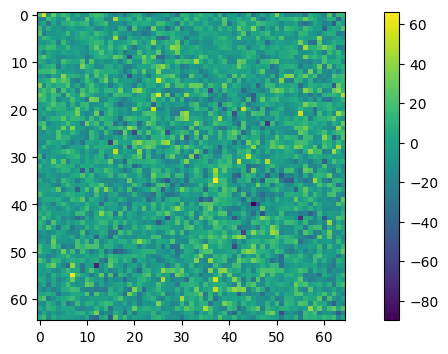

In [4]:
_, ax = plt.subplots(figsize=(10, 4))

im = ax.imshow(sensor_data[3666, :, :])
plt.colorbar(im, ax=ax)
plt.show()

# Preprocessing

## Removing outliers

In [9]:
def remove_outliers(data):
    """
    Remove artefacts in a recording in a quick and dirty 
    way: all values above and below 500 (a.u.) are cut.

    Note: there should be none in the recording.
    """

    data[data > 500] = 0
    data[data < -500] = 0
    
    return data

In [10]:
data = remove_outliers(data)

In [6]:
data.shape

(100000, 4225)

## Creating SpikeInterface object

In [11]:
from probeinterface import read_prb 
import spikeinterface.core as sc

recording = sc.NumpyRecording(
    data, sampling_frequency=25000
)

# Set probe
probe = read_prb(probepath)
# Not sure why but we get a ProbeGroup instead of a Probe
# Also, why is this operation not in place? 
recording = recording.set_probegroup(probe)
print(recording)

NumpyRecording: 4225 channels - 25.0kHz - 1 segments - 100,000 samples - 4.00s - int16 dtype 
                805.85 MiB


## Basic preprocessing steps

In [12]:
import spikeinterface.preprocessing as sp

recording_cmr = sp.common_reference(
    recording, reference='global', operator='median'
)
recording_filt = sp.highpass_filter(
    recording_cmr, freq_min=300
)
recording_white = sp.whiten(
    recording_filt, dtype='float32'
)
recording_white

WhitenRecording: 4225 channels - 25.0kHz - 1 segments - 100,000 samples - 4.00s - float32 dtype 
                 1.57 GiB

# Testing 

## Take a subset of the data

In [9]:
# Select a subset of the recording to avoid crashing the computer
n_s = 4
fs = recording_white.get_sampling_frequency()
recording_sub = recording_white.frame_slice(
    start_frame=0*fs, end_frame=n_s*fs
)
recording_sub

FrameSliceRecording: 4225 channels - 25.0kHz - 1 segments - 100,000 samples - 4.00s 
                     float32 dtype - 1.57 GiB

## Caching data

In [10]:
"""
https://github.com/SpikeInterface/spikeinterface/issues/311
A NumpyRecording object is not dumpable because it is a 'in memory' object.
So we need to cache it. Of course. It's perfectly obvious.
"""

cached = recording_sub.save(folder='temp/', overwrite=True)
cached

write_binary_recording with n_jobs = 1 and chunk_size = 25000


write_binary_recording:   0%|          | 0/4 [00:00<?, ?it/s]

BinaryFolderRecording: 4225 channels - 25.0kHz - 1 segments - 100,000 samples - 4.00s 
                       float32 dtype - 1.57 GiB

## Loading cached data

In [1]:
import spikeinterface.core as sc

cached = sc.load_extractor('temp/')
cached

BinaryFolderRecording: 4225 channels - 25.0kHz - 1 segments - 100,000 samples - 4.00s 
                       float32 dtype - 1.57 GiB

## IronClust

In [2]:
import spikeinterface.sorters as ss

sorter = 'ironclust'
ss.get_default_sorter_params(sorter)
ss.get_sorter_params_description(sorter)

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

In [4]:
sorting = ss.run_sorter(
    sorter_name=sorter,
    recording=cached,
    output_folder=f"results/{sorter}",
    remove_existing_folder=True,
    verbose=True,
    docker_image="spikeinterface/ironclust-compiled-base"
)

ironclust supports GPU, but no GPU is available.
Running the sorter without GPU
Docker: pulling image spikeinterface/ironclust-compiled-base
Starting container
Installing spikeinterface==0.99.1 in spikeinterface/ironclust-compiled-base
Running ironclust sorter inside spikeinterface/ironclust-compiled-base
Stopping container


## Mountain Sort 5

In [80]:
from mountainsort5.util import create_cached_recording
from tempfile import TemporaryDirectory
import mountainsort5 as ms5
import time


with TemporaryDirectory() as tmpdir:
    # Cache the recording to a temporary directory for efficient reading
    recording_cached = create_cached_recording(recording_filt, folder=tmpdir)

    # Sorting
    print('Starting MountainSort5 (sorting1)')
    timer = time.time()
    result = ms5.sorting_scheme2(
        recording_cached,
        sorting_parameters=ms5.Scheme2SortingParameters(
            phase1_detect_channel_radius=150,
            detect_channel_radius=50,
            max_num_snippets_per_training_batch=3, # for improving test coverage
            snippet_mask_radius=150,
            training_duration_sec=15
        ),
        return_snippet_classifiers=True # for coverage
    )
    assert isinstance(result, tuple)
    sorting1, classifer1 = result

print('Starting MountainSort5 (sorting2)')
timer = time.time()
sorting2 = ms5.sorting_scheme2( # noqa
    recording_filt,
    sorting_parameters=ms5.Scheme2SortingParameters(
        phase1_detect_channel_radius=150,
        detect_channel_radius=50,
        training_duration_sec=25,
        training_recording_sampling_mode='uniform'
    )
)
elapsed_sec = time.time() - timer
duration_sec = recording.get_total_duration()
print(f'Elapsed time for sorting: {elapsed_sec:.2f} sec -- x{(duration_sec / elapsed_sec):.2f} speed compared with real time for {recording.get_num_channels()} channels')

# commenting out because this step takes a while
# print('Comparing with truth')
# comparison = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting)
# print(comparison.get_performance())

write_binary_recording:   0%|          | 0/1 [00:00<?, ?it/s]

Starting MountainSort5 (sorting1)
Using training recording of duration 15 sec with the sampling mode initial
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.001 seconds ***
Running phase 1 sorting
Number of channels: 4225
Number of timepoints: 100000
Sampling frequency: 25000 Hz
Channel 0: [0. 0.]
Channel 1: [ 0. 16.]
Channel 2: [ 0. 32.]
Channel 3: [ 0. 48.]
Channel 4: [ 0. 64.]
Channel 5: [ 0. 80.]
Channel 6: [ 0. 96.]
Channel 7: [  0. 112.]
Channel 8: [  0. 128.]
Channel 9: [  0. 144.]
Channel 10: [  0. 160.]
Channel 11: [  0. 176.]
Channel 12: [  0. 192.]
Channel 13: [  0. 208.]
Channel 14: [  0. 224.]
Channel 15: [  0. 240.]
Channel 16: [  0. 256.]
Channel 17: [  0. 272.]
Channel 18: [  0. 288.]
Channel 19: [  0. 304.]
Channel 20: [  0. 320.]
Channel 21: [  0. 336.]
Channel 22: [  0. 352.]
Channel 23: [  0. 368.]
Channel 24: [  0. 384.]
Channel 25: [  0. 400.]
Channel 26: [  0. 416.]
Channel 27: [  0. 432.]
Channel 28: [  0. 448.]
Channel 29: [  0. 464.]
Cha

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



m = 0 (nbhd size: 79)
m = 1 (nbhd size: 89)
m = 2 (nbhd size: 99)
m = 3 (nbhd size: 108)
m = 4 (nbhd size: 117)
m = 5 (nbhd size: 125)
m = 6 (nbhd size: 133)
m = 7 (nbhd size: 140)
m = 8 (nbhd size: 145)
m = 9 (nbhd size: 148)
m = 10 (nbhd size: 148)
m = 11 (nbhd size: 148)
m = 12 (nbhd size: 148)
m = 13 (nbhd size: 148)
m = 14 (nbhd size: 148)
m = 15 (nbhd size: 148)
m = 16 (nbhd size: 148)
m = 17 (nbhd size: 148)
m = 18 (nbhd size: 148)
m = 19 (nbhd size: 148)
m = 20 (nbhd size: 148)
m = 21 (nbhd size: 148)
m = 22 (nbhd size: 148)
m = 23 (nbhd size: 148)
m = 24 (nbhd size: 148)
m = 25 (nbhd size: 148)
m = 26 (nbhd size: 148)
m = 27 (nbhd size: 148)
m = 28 (nbhd size: 148)
m = 29 (nbhd size: 148)
m = 30 (nbhd size: 148)
m = 31 (nbhd size: 148)
m = 32 (nbhd size: 148)
m = 33 (nbhd size: 148)
m = 34 (nbhd size: 148)
m = 35 (nbhd size: 148)
m = 36 (nbhd size: 148)
m = 37 (nbhd size: 148)
m = 38 (nbhd size: 148)
m = 39 (nbhd size: 148)
m = 40 (nbhd size: 148)
m = 41 (nbhd size: 148)
m = 4

MemoryError: Unable to allocate 7.99 GiB for an array with shape (169000, 12685) and data type float32

Exception ignored in: 'scipy.linalg._decomp_lu_cython.lu_decompose'
Traceback (most recent call last):
  File "C:\Users\roque\anaconda3\envs\spikesorting\lib\site-packages\scipy\linalg\_decomp_lu.py", line 313, in lu
    lu_dispatcher(a1, u, p, permute_l)
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 7.99 GiB for an array with shape (169000, 12685) and data type float32


NotADirectoryError: [WinError 267] Nom de répertoire non valide: 'C:\\Users\\roque\\AppData\\Local\\Temp\\tmpy0d8wban\\recording.dat'

## SpyKING Circus 2

In [15]:
import spikeinterface.sorters as ss

sorter = 'spykingcircus2'
ss.get_default_sorter_params(sorter)

{'general': {'ms_before': 2, 'ms_after': 2, 'radius_um': 100},
 'waveforms': {'max_spikes_per_unit': 200,
  'overwrite': True,
  'sparse': True,
  'method': 'ptp',
  'threshold': 1},
 'filtering': {'freq_min': 150, 'dtype': 'float32'},
 'detection': {'peak_sign': 'neg', 'detect_threshold': 5},
 'selection': {'n_peaks_per_channel': 5000, 'min_n_peaks': 20000},
 'localization': {},
 'clustering': {},
 'matching': {},
 'apply_preprocessing': True,
 'shared_memory': True,
 'job_kwargs': {'n_jobs': -1}}

In [2]:
general = {
    'ms_before': 2, 'ms_after': 2, 'radius_um': 250
}
detection = {
    'peak_sign': 'neg', 'detect_threshold': 3
}

sorting = ss.run_sorter(
    sorter_name=sorter,
    recording=cached,
    output_folder=f"results/{sorter}",
    remove_existing_folder=True,
    verbose=True,
    apply_preprocessing=False,
    general=general,
    detection=detection
)

detect peaks using locally_exclusive with n_jobs = 8 and chunk_size = 25000


detect peaks using locally_exclusive:   0%|          | 0/2 [00:00<?, ?it/s]

We found 3509 peaks in total
We kept 3509 peaks for clustering
extracting features with n_jobs = 8 and chunk_size = 25000


extracting features:   0%|          | 0/2 [00:00<?, ?it/s]

We found 12 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/2 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/2 [00:00<?, ?it/s]

We kept 12 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/2 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 8 and chunk_size = 25000


extract waveforms shared_memory multi buffer:   0%|          | 0/2 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 8 and chunk_size = 2500


find spikes (circus-omp-svd):   0%|          | 0/20 [00:00<?, ?it/s]

We found 0 spikes
spykingcircus2 run time 203.69s


## HerdingSpikes

In [12]:
import spikeinterface.sorters as ss

sorter = 'herdingspikes'
ss.get_sorter_params_description(sorter)

{'clustering_bandwidth': 'Meanshift bandwidth, average spatial extent of spike clusters (um)',
 'clustering_alpha': 'Scalar for the waveform PC features when clustering.',
 'clustering_n_jobs': 'Number of cores to use for clustering.',
 'clustering_bin_seeding': 'Enable clustering bin seeding.',
 'clustering_min_bin_freq': 'Minimum spikes per bin for bin seeding.',
 'clustering_subset': 'Number of spikes used to build clusters. All by default.',
 'left_cutout_time': 'Cutout size before peak (ms).',
 'right_cutout_time': 'Cutout size after peak (ms).',
 'detect_threshold': 'Detection threshold',
 'probe_masked_channels': 'Masked channels',
 'probe_inner_radius': 'Radius of area around probe channel for localization',
 'probe_neighbor_radius': 'Radius of area around probe channel for neighbor classification.',
 'probe_event_length': 'Duration of a spike event (ms)',
 'probe_peak_jitter': 'Maximum peak misalignment for synchronous spike (ms)',
 't_inc': 'Number of samples per chunk during

In [13]:
ss.get_default_sorter_params(sorter)

{'clustering_bandwidth': 5.5,
 'clustering_alpha': 5.5,
 'clustering_n_jobs': -1,
 'clustering_bin_seeding': True,
 'clustering_min_bin_freq': 16,
 'clustering_subset': None,
 'left_cutout_time': 0.3,
 'right_cutout_time': 1.8,
 'detect_threshold': 20,
 'probe_masked_channels': [],
 'probe_inner_radius': 70,
 'probe_neighbor_radius': 90,
 'probe_event_length': 0.26,
 'probe_peak_jitter': 0.2,
 't_inc': 100000,
 'num_com_centers': 1,
 'maa': 12,
 'ahpthr': 11,
 'out_file_name': 'HS2_detected',
 'decay_filtering': False,
 'save_all': False,
 'amp_evaluation_time': 0.4,
 'spk_evaluation_time': 1.0,
 'pca_ncomponents': 2,
 'pca_whiten': True,
 'freq_min': 300.0,
 'freq_max': 6000.0,
 'filter': True,
 'pre_scale': True,
 'pre_scale_value': 20.0,
 'filter_duplicates': True}

In [15]:
"""
To prevent an error with numpy np.bool and np.int not existing anymore,
I made modifications here:
C:/Users/roque/anaconda3/envs/spikesorting/Lib/site-packages/herdingspikes/clustering
in the file mean_shift.py
"""

sorting = ss.run_sorter(
    sorter_name=sorter,
    recording=cached,
    output_folder=f"results/{sorter}",
    remove_existing_folder=True,
    verbose=True,
    filter=False,
    detect_threshold=10,
    probe_neighbor_radius=250,
    pre_scale_value=100,
    clustering_bandwidth=None
)

# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 25000
# Localization On
# Number of recorded channels: 4225
# Analysing frames: 100000; Seconds: 4.0
# Frames before spike in cutout: 8
# Frames after spike in cutout: 45
# tcuts: 33 70
# tInc: 99897
# Detection completed, time taken: 0:00:11.507184
# Time per frame: 0:00:00.115072
# Time per sample: 0:00:00.000027
Loaded 1608 spikes.
Fitting dimensionality reduction using all spikes...
...projecting...
...done
Clustering...
Clustering 1608 spikes...
number of seeds: 22
seeds/job: 3
using 8 cpus


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.4s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished


Number of estimated units: 5
Saving to C:\Users\roque\Desktop\These\Travail\Codes\SpikeSorting\results\herdingspikes\sorter_output\HS2_sorted.hdf5
herdingspikes run time 56.96s


In [16]:
sorting

HerdingspikesSortingExtractor: 5 units - 1 segments - 25.0kHz
  file_path: C:\Users\roque\Desktop\These\Travail\Codes\SpikeSorting\results\herdingspikes\sorter_output\HS2_sorted.hdf5

## Our method

# Loading ground truth

In [3]:
gt_path = "data/rgcElStim/sorted/wildtype/2017-11-03/2017.11.03-11.45.52-spontan_1.cmtr"

## Exploratory analysis 

In [52]:
import h5py

"""
File contains 4 groups:
    - Acquisition: unavailable, points to the original source folder of the recording
    - Activity Summary.
    - Filter Tool.
    - Spike Sorter.

    We learn that the data was 
        - High-pass filterd at 100 Hz
        - Low-pass filtered at 12000 Hz
"""

with h5py.File(gt_path, "r") as f:

    # Activity Summary
    # print(f['Activity Summary'].keys())
    # print(f.get('Activity Summary/SettingsMapCreator')[()])
    # print(f.get('Activity Summary/SettingsSpikeDetector')[()])
    # print(f.get('Activity Summary/SettingsSummaryTool')[()])
    # print(f.get('Activity Summary/SpikeMeta')[()])

    # Filter Tool
    # print(f['Filter Tool'].keys())
    # print(f.get('Filter Tool/Pipe').keys())
    # print(f.get('Filter Tool/Pipe/1 Offset')[()])
    # print(f.get('Filter Tool/Pipe/2 High-Pass')[()])
    # print(f.get('Filter Tool/Pipe/3 Low-Pass')[()])
    # print(f.get('Filter Tool/SettingsFilterTool')[()])
    
    # Spike Sorter
    print(f['Spike Sorter'].keys())
    print(f.get('Spike Sorter/Projection Matrix')[()].shape)
    print(f.get('Spike Sorter/SettingsPeakDetection')[()])
    print(f.get('Spike Sorter/SettingsPostProcessing')[()])
    print(f.get('Spike Sorter/SettingsRoiDetection')[()])
    print(f.get('Spike Sorter/SettingsSorterComputing')[()])
    print(f.get('Spike Sorter/SettingsSorterGeneral')[()])
    print(f.get('Spike Sorter/SettingsSpikeSorter')[()])
    print('')
    print(f.get('Spike Sorter/Unit 1').keys())
    print(f.get('Spike Sorter/Unit 1/Peaks').dtype.fields.keys())
    print(f.get('Spike Sorter/Unit 1/RoiSTAs'))
    print(f.get('Spike Sorter/Unit 1/Source'))
    print(f.get('Spike Sorter/Unit 1/Unit Info').dtype.fields.keys())
    print(f.get('Spike Sorter/Unit 1/Unmixing'))

<KeysViewHDF5 ['Projection Matrix', 'SettingsPeakDetection', 'SettingsPostProcessing', 'SettingsRoiDetection', 'SettingsSorterComputing', 'SettingsSorterGeneral', 'SettingsSpikeSorter', 'Unit 1', 'Unit 10', 'Unit 11', 'Unit 12', 'Unit 13', 'Unit 14', 'Unit 15', 'Unit 16', 'Unit 17', 'Unit 18', 'Unit 19', 'Unit 2', 'Unit 20', 'Unit 21', 'Unit 22', 'Unit 23', 'Unit 24', 'Unit 25', 'Unit 26', 'Unit 27', 'Unit 28', 'Unit 29', 'Unit 3', 'Unit 30', 'Unit 4', 'Unit 5', 'Unit 6', 'Unit 7', 'Unit 8', 'Unit 9', 'Units']>
(5, 30, 4225)
[(0, 0, 3., b'ExponentialGMM', 0.05, 500)]
[(0.5, 0.1, 1, 1, 16, 0.5, 0.5, 500, 1000)]
[(2., 0.1, 169, 0.7, 1, 1, 1)]
[(4, 20000000, 0, 60000000, 2147483648)]
[(5, b'EvdBased', 5, b'Absolute', 2000, 30, 1000, -4, 0)]
[(b'True', b'HDF5', b'Complete', b'Aggregate')]

<KeysViewHDF5 ['Peaks', 'RoiSTAs', 'Source', 'Unit Info', 'Unmixing']>
dict_keys(['Timestamp', 'PeakAmplitude', 'IncludePeak', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '

## Actual implementation

In [4]:
import pandas as pd
import numpy as np
import h5py


def load_gt(path):
    """
    Part of this code was adapted from:
    https://github.com/lhoefling/rgc-elstim-modeling/blob/master/src/analysis/spikes.py
    """
    
    gt_dict = {
        't': [],
        'Unit': [],
        'Column': [],
        'Row': []
    }
    
    with h5py.File(path, 'r') as f:
    
        # Get units data from spike sorter data (considered as ground truth)
        units = [
            f.get(f'Spike Sorter/{key}') for key 
            in f['Spike Sorter'].keys()
            if 'Unit ' in key
        ]
        
        # Parse unit data (should be done while the file is still open!)
        for unit in units:
    
            # Get unit id
            unit_id = int(unit.name.split(' ')[-1])
            
            # Get peak data
            peaks = unit['Peaks']
            mask = np.array(peaks['IncludePeak'], dtype=bool)
            t = peaks['Timestamp'][mask] * 0.001 # in ms 
    
            # Get position data (returns an array of one element)
            row = unit['Unit Info']['Row'][0]
            col = unit['Unit Info']['Column'][0]
            
            # Save data
            n = len(t)
            gt_dict['t'] += list(t)
            gt_dict['Unit'] += [unit_id] * n
            gt_dict['Column'] += [col] * n
            gt_dict['Row'] += [row] * n
    
    
    return pd.DataFrame(data=gt_dict)

In [5]:
df_gt = load_gt(gt_path)
df_gt

,t,Unit,Column,Row
0,0.50,1,53,48
1,18.65,1,53,48
2,23.35,1,53,48
3,41.60,1,53,48
4,52.50,1,53,48
...,...,...,...,...
8794,4926.10,9,57,57
8795,4931.45,9,57,57
8796,4940.55,9,57,57
8797,4961.65,9,57,57


In [6]:
import spikeinterface.extractors as se

# Create SpikeInterface object
ground_truth = se.NumpySorting.from_times_labels(
    df_gt['t'].to_numpy(), 
    df_gt['Unit'].to_numpy(), 
    sampling_frequency=25000
)
ground_truth

NumpySorting: 30 units - 1 segments - 25.0kHz

# Comparison

## Load sorting results

### HerdingSpikes

In [17]:
sorting = ss.read_sorter_folder(
    "results/herdingspikes", 
)
print(sorting)

HerdingspikesSortingExtractor: 5 units - 1 segments - 25.0kHz
  file_path: C:\Users\roque\Desktop\These\Travail\Codes\SpikeSorting\results\herdingspikes\sorter_output\HS2_sorted.hdf5


### IronClust

In [8]:
sorting_ironclust = ss.read_sorter_folder(
    "results/ironclust", 
)
print(sorting_ironclust)

MdaSortingExtractor: 12 units - 1 segments - 25.0kHz
  file_path: c:\Users\roque\Desktop\These\Travail\Codes\SpikeSorting\results\ironclust\sorter_output\tmp\firings.mda


### Our method

## Performance

In [9]:
import spikeinterface.comparison as scomp

### HerdingSpikes

In [30]:
comp_hs = scomp.compare_sorter_to_ground_truth(
    ground_truth, sorting,
    gt_name='Ground Truth', tested_name='HerdingSpikes',
    exhaustive_gt=True,
    match_mode='best'
)
comp_hs

In [31]:
comp_hs.get_performance()

,accuracy,recall,precision,false_discovery_rate,miss_rate
gt_unit_id,,,,,
1,0.114688,0.129841,0.495652,0.504348,0.870159
2,0.104396,0.116803,0.495652,0.504348,0.883197
3,0.117517,0.136247,0.46087,0.53913,0.863753
4,0.146739,0.254717,0.257143,0.742857,0.745283
5,0.121839,0.142091,0.46087,0.53913,0.857909
6,0.119247,0.135714,0.495652,0.504348,0.864286
7,0.111702,0.201923,0.2,0.8,0.798077
8,0.148876,0.180272,0.46087,0.53913,0.819728
9,0.126437,0.174603,0.314286,0.685714,0.825397


<Figure size 800x800 with 0 Axes>

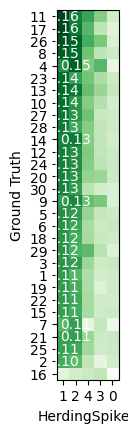

In [37]:
import spikeinterface.widgets as sw

sw.plot_agreement_matrix(comp_hs, ordered=True)
plt.show()

In [39]:
perf = comp_hs.get_performance()

accuracy = perf['accuracy'].mean()
recall = perf['recall'].mean()
precision = perf['precision'].mean()
print(f'Accuracy = {accuracy}; Recall = {recall}; Precision = {precision}')

Accuracy = 0.12401817373747777; Recall = 0.1587939824242869; Precision = 0.3951552795031056


### IronClust

In [10]:
comp_hs = scomp.compare_sorter_to_ground_truth(
    ground_truth, sorting_ironclust,
    gt_name='Ground Truth', tested_name='IronClust',
    exhaustive_gt=True,
    match_mode='best'
)
comp_hs

In [11]:
comp_hs.get_performance()

,accuracy,recall,precision,false_discovery_rate,miss_rate
gt_unit_id,,,,,
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0


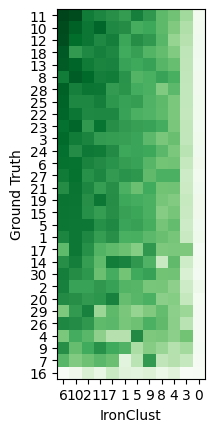

In [12]:
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt

sw.plot_agreement_matrix(comp_hs, ordered=True)
plt.show()

In [20]:
perf = comp_hs.get_performance()

accuracy = perf['accuracy'].mean()
recall = perf['recall'].mean()
precision = perf['precision'].mean()
print(f'Accuracy = {accuracy}; Recall = {recall}; Precision = {precision}')

Accuracy = 0.0; Recall = 0.0; Precision = 0.0


### Our method